# Project 2: Topic Classification

In this project, I worked with text data from newsgroup postings on a variety of topics to train classifiers to distinguish between the topics based on the text of the posts. Each document will be represented using a "bag-of-words" model, making the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words, order is not important.

SK-learn documentation was used throughout this project:
http://scikit-learn.org/stable/modules/feature_extraction.html


In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
from sklearn.feature_extraction.text import CountVectorizer


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. I further split the test so I have a dev set. Note that I specified 4 categories to use for this project to help limit scope. Without this you would get all 20 categories.

In [3]:

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


I've printed the first 5 training examples along with the label for reference. This should give us a good idea of the nature of the text being classified.

In [3]:
# Print 5 Training Examples

for i, word in enumerate(train_data):
    print '\033[1m' + 'Training Example #' , i+1 , '\033[1m' + '\n Text: \n' + '\033[0m', word, '\033[1m' + '\n \n Label: ' + '\033[0m', train_labels[i], '\n \n'
    if i+1 >=5:
        break

Training Example # 1 
 Text: 
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 
 
 Label:  1 
 

Training Example # 2 
 Text: 
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corrupt

Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.


In [4]:

# Question 2a:
countVector = CountVectorizer()
sparseMatrix = countVector.fit_transform(train_data)

# Get size of vocabulary, number or examples and count on non-zero values
features = sparseMatrix.shape[1]
examples = sparseMatrix.shape[0]
nnzCount = sparseMatrix.nnz
nnzAvg = nnzCount/examples
nnzFrac = nnzCount/(features*examples)

# Print Answer to Question 2a
print '\033[1m' + 'Answer A: ' + '\033[0m'
print 'The size of the vocabulary is: ', features, ' features'
print 'The average number of non-zero features per example is: ', nnzAvg
print 'The fraction of non-zero entries in the matrix is: ', nnzCount, '/', '(', features, '*', examples, ')', ' or roughly 0.36% \n'

# Question 2b:
featureNames = countVector.get_feature_names()
featureNames.sort()

# Print Answer to Question 2b
print '\033[1m' + 'Answer B:' + '\033[0m'
print 'The 0th feature is: ', featureNames[0]
print 'The last feature is: ', featureNames[-1], '\n'

# Question 2c
myVocab = ['atheism', 'graphics', 'space', 'religion']
countVector = CountVectorizer(vocabulary = myVocab)
newMatrix = countVector.fit_transform(train_data)

# Generate average of non-zero values per account
newNnzCount = float(newMatrix.nnz)
newExamples = float(newMatrix.shape[0])
newNnzAvg = newNnzCount/newExamples

# Print Answer to Question 2c
print '\033[1m' + 'Answer C:' + '\033[0m'
print 'Confirming the vector is properly shaped: ', newMatrix.shape
print 'Number of non-zero features per example: ', "%.3f" % newNnzAvg, '\n'

# Question 2d
countVector = CountVectorizer(ngram_range = (2,3), analyzer = 'word')
ngramMatrix = countVector.fit_transform(train_data)

# Print Answer to Question 2d
print '\033[1m' + 'Answer D:' + '\033[0m'
print 'Vocabulary for 2/3-gram words: ', ngramMatrix.shape[1], '\n'

# Question 2e
countVector = CountVectorizer(ngram_range = (2,3), analyzer = 'word', min_df=10)
ngramMatrix = countVector.fit_transform(train_data)

# Print Answers to Question 2e
print '\033[1m' + 'Answer E:' + '\033[0m'
print 'Vocabulary for 2/3-gram words with 10 doc minimum:', ngramMatrix.shape[1], '\n'

# Question 2f
countVector = CountVectorizer()
trainMatrix = countVector.fit_transform(train_data)
devMatrix = countVector.fit_transform(dev_data)

trainVocab = trainMatrix.shape[1]
devVocab = devMatrix.shape[1]

# Print Answers to Question 2f
print '\033[1m' + 'Answer F:' + '\033[0m'
print 'Train data Vocabulary: ', trainVocab, ' words'
print 'Dev data Vocabulary:', devVocab, ' words'
print 'Difference in Vocabulary:', trainVocab - devVocab, ' words'


Answer A: 
The size of the vocabulary is:  26879  features
The average number of non-zero features per example is:  96
The fraction of non-zero entries in the matrix is:  196700 / ( 26879 * 2034 )  or roughly 0.36% 

Answer B:
The 0th feature is:  00
The last feature is:  zyxel 

Answer C:
Confirming the vector is properly shaped:  (2034, 4)
Number of non-zero features per example:  0.268 

Answer D:
Vocabulary for 2/3-gram words:  510583 

Answer E:
Vocabulary for 2/3-gram words with 10 doc minimum: 3381 

Answer F:
Train data Vocabulary:  26879  words
Dev data Vocabulary: 16246  words
Difference in Vocabulary: 10633  words


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.


In [11]:
# Transforming Train and Dev data
countVector = CountVectorizer()
trainMatrix = countVector.fit_transform(train_data)
devMatrix = countVector.transform(dev_data)

# Training KNN model on trainMatrix
print '\033[1m' + 'K-Nearest Neighbors ' + '\033[0m'

knnModel = KNeighborsClassifier(weights='uniform')
knnModel.fit(trainMatrix, train_labels)
knnPred = knnModel.predict(devMatrix)
print 'The value for K was: K = 5'
print 'The F1 score for a standard KNN model is: ', metrics.f1_score(dev_labels, knnPred, average = 'weighted')

knn_ks = list(range(101))
knn_ks = knn_ks[1:100]

# Identifying best value of K
knnParams = {'n_neighbors': knn_ks}
knnOptimal = GridSearchCV(knnModel, knnParams, cv = 5)
knnOptimal.fit(trainMatrix, train_labels)
knnPred = knnOptimal.predict(devMatrix)
print knnOptimal.best_estimator_
print 'The optimal value for K was: K = 96' 
print 'The F1 score for a KNN model with optimal K is: ', metrics.f1_score(dev_labels, knnPred, average = 'weighted')

# Training Naive Bayes on trainMatrix
print '\033[1m' + 'Multinomial Naive Bayes ' + '\033[0m'

multiNB = MultinomialNB()
multiNB.fit(trainMatrix, train_labels)
multiNB_Pred = multiNB.predict(devMatrix)
print 'The F1 score for a standard Multinomial NB model is: ', metrics.f1_score(dev_labels, multiNB_Pred, average = 'weighted')

# Creating a range function to generate decimal values for alpha instead of integer values
import decimal

def drange(x, y, jump):
  while x < y:
    yield float(x)
    x += decimal.Decimal(jump)

# Limiting the range of alpha to improve performance against dev set and prevent model from overfitting
mnb_alpha = list(drange(0,1.05,0.025))
mnb_alpha = mnb_alpha[4:41]
multiNB_Params = {'alpha': mnb_alpha}

# Creating optimal MultinomialNA model and predicting against dev set
multiNB_Optimal = GridSearchCV(multiNB, multiNB_Params , cv = 5)
multiNB_Optimal.fit(trainMatrix, train_labels)
multiNB_Pred = multiNB_Optimal.predict(devMatrix)

print multiNB_Optimal.best_estimator_
print 'The optimal value of alpha was 0.1'
print 'The F1 score for a Multinomial NB model is: ', metrics.f1_score(dev_labels, multiNB_Pred, average = 'weighted')

print '\033[1m' + 'Logistic Regression' + '\033[0m'

logReg = LogisticRegression(solver = 'liblinear', multi_class = 'auto')
logReg.fit(trainMatrix, train_labels)
logRegPred = logReg.predict(devMatrix)
print 'The F1 score for a standard Logistic Regression model is: ', metrics.f1_score(dev_labels, logRegPred, average = 'weighted')

# Finding optimal value of C (Note: Default "penalty = l2")

c_value = 0.05
f1 = 0
optimal_c = 0
while c_value <= 1:
    logReg = LogisticRegression(C = c_value, solver = 'liblinear', multi_class = 'auto')
    logReg.fit(trainMatrix, train_labels)
    logRegPred = logReg.predict(devMatrix)
    if f1 < metrics.f1_score(dev_labels, logRegPred, average = 'weighted'):
        f1 = metrics.f1_score(dev_labels, logRegPred, average = 'weighted')
        optimal_c = c_value
    c_value += 0.05

print 'The optimal value of C is', optimal_c, 'with an F1 score of ', f1, '\n'

# Ouputting values for the Sum Squared Weight per class at each interval of C  

print '\033[1m' + 'Logistic Regression - C-values and Sum of Squared Weights by Class' + '\033[0m'
c_value=0.1
while c_value <= 1:
    logReg = LogisticRegression(C = c_value)
    logReg.fit(trainMatrix, train_labels)
    logRegCoef = np.array(logReg.coef_)
    firstClass = np.array(logRegCoef[0]).tolist()
    secondClass = np.array(logRegCoef[1]).tolist()
    thirdClass = np.array(logRegCoef[2]).tolist()
    fourthClass = np.array(logRegCoef[3]).tolist()
    for index, i in enumerate(firstClass):
        firstClass[index] = i*i
    for index, i in enumerate(secondClass):
        secondClass[index] = i*i
    for index, i in enumerate(thirdClass):
        thirdClass[index] = i*i
    for index, i in enumerate(fourthClass):
        fourthClass[index] = i*i
    print 'C = ', c_value, ' | ', 'Sum Squared Weight (Class 1) = ', np.sum(firstClass)
    print 'C = ', c_value, ' | ', 'Sum Squared Weight (Class 2) = ', np.sum(secondClass)
    print 'C = ', c_value, ' | ', 'Sum Squared Weight (Class 3) = ', np.sum(thirdClass)
    print 'C = ', c_value, ' | ', 'Sum Squared Weight (Class 4) = ', np.sum(fourthClass), '\n'
    c_value += 0.1


K-Nearest Neighbors 
The value for K was: K = 5
The F1 score for a standard KNN model is:  0.4287607236218357
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=96, p=2,
           weights='uniform')
The optimal value for K was: K = 96
The F1 score for a KNN model with optimal K is:  0.44834460532500914
Multinomial Naive Bayes 
The F1 score for a standard Multinomial NB model is:  0.7777320236017224
MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
The optimal value of alpha was 0.1
The F1 score for a Multinomial NB model is:  0.7903052385098862
Logistic Regression
The F1 score for a standard Logistic Regression model is:  0.6944172871853819
The optimal value of C is 0.55 with an F1 score of  0.7119386537206766 

Logistic Regression - C-values and Sum of Squared Weights by Class
C =  0.1  |  Sum Squared Weight (Class 1) =  27.136235111511485
C =  0.1  |  Sum Squared Weight (Class 2) =  24.65956732346

A.) Given the sparse nature of the data, we would have expected the poor f-1 score from KNN. Additionally, Since KNN's objective function is standard euclidean distance as the dimensions of the data increases KNN performance begins to drop off. For both of these reasons I would expect consistently poor performance from KNN given this data.

B.) When considering the relative performance of our Logistic Regression and our Multinomial Naive Bayes model we must first consider our data set and associated labels. What we are trying to predict is one of four classes. As we know, Logistic Regression performs best when the dependent variable is binary (i.e. Spam vs Ham). Since this isn't the case with the problem at hand (classifying 0, 1, 2 and 3), we would expect the Multinomial Naive Bayes to outperform the logistic regression despite the large number of features in the data set working against Naive Bayes' fundamental assumption of indepenence amongst input variables.

C.) First, we know that C is the inverse of regularization strength. So, a lower C value indicates more smoothing. Regularization penalizes increasing the weight or magnitude of your parameters. At lower values of C, there is more regularization and therefore the sum of squared weights should reduce in value. At higher values of C, there is less regularization and therefore the sum of squared weights should increase in value. Given that we have a lot of parameters its likely that we are overfitting our model to idiosyncracies in our training data. Ultimately this should help to make our model more generalizable.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [12]:

countVector = CountVectorizer()
trainMatrix = countVector.fit_transform(train_data)
featureNames = countVector.get_feature_names()

logReg = LogisticRegression(C = 0.56)
logReg.fit(trainMatrix, train_labels)
logRegCoef = np.array(logReg.coef_)


# Create Array of Weights per class
firstClass = np.array(logRegCoef[0]).tolist()
secondClass = np.array(logRegCoef[1]).tolist()
thirdClass = np.array(logRegCoef[2]).tolist()
fourthClass = np.array(logRegCoef[3]).tolist()

featWeights = []
firstClassFeat = [[0,0],[0,0],[0,0],[0,0],[0,0]]
for index, i in enumerate(firstClass):
    for num, j in enumerate(firstClassFeat):
        if i > j[1]:
            firstClassFeat.insert(num, [0,i,index,featureNames[index]])
            firstClassFeat.pop()
            break

secondClassFeat = [[0,0],[0,0],[0,0],[0,0],[0,0]]
for index, i in enumerate(secondClass):
    for num, j in enumerate(secondClassFeat):
        if i > j[1]:
            secondClassFeat.insert(num, [1,i,index, featureNames[index]])
            secondClassFeat.pop()
            break

thirdClassFeat = [[0,0],[0,0],[0,0],[0,0],[0,0]]
for index, i in enumerate(thirdClass):
    for num, j in enumerate(thirdClassFeat):
        if i > j[1]:
            thirdClassFeat.insert(num, [2,i,index, featureNames[index]])
            thirdClassFeat.pop()
            break
fourthClassFeat = [[0,0],[0,0],[0,0],[0,0],[0,0]]
for index, i in enumerate(fourthClass):
    for num, j in enumerate(fourthClassFeat):
        if i > j[1]:
            fourthClassFeat.insert(num, [3,i,index, featureNames[index]])
            fourthClassFeat.pop()
            break

[ firstClassFeat.extend([i]) for i in secondClassFeat]
[ firstClassFeat.extend([i]) for i in thirdClassFeat] 
[ firstClassFeat.extend([i]) for i in fourthClassFeat] 
            
classification = np.array(firstClassFeat)[:,0]
weight = np.array(firstClassFeat)[:,1]
word = np.array(firstClassFeat)[:,3]

classification = classification.tolist()
weight = weight.tolist()
word = word.tolist()

print '\033[1m' + 'Highest Weighted Features by Class' + '\033[0m'

df = {'class': classification, 'weight': weight, 'word': word}
dataFrame = pd.DataFrame(data=df)
print dataFrame



# Highest Weighted Bi-gram Features by Class

countVector = CountVectorizer(ngram_range = (2,2), analyzer = 'word')
bigramMatrix = countVector.fit_transform(train_data)
logReg.fit(bigramMatrix, train_labels)
logRegCoef = np.array(logReg.coef_)
featureNames = countVector.get_feature_names()

firstClass = np.array(logRegCoef[0]).tolist()
secondClass = np.array(logRegCoef[1]).tolist()
thirdClass = np.array(logRegCoef[2]).tolist()
fourthClass = np.array(logRegCoef[3]).tolist()

featWeights = []
firstClassFeat = [[0,0],[0,0],[0,0],[0,0],[0,0]]
for index, i in enumerate(firstClass):
    for num, j in enumerate(firstClassFeat):
        if i > j[1]:
            firstClassFeat.insert(num, [0,i,index,featureNames[index]])
            firstClassFeat.pop()
            break

secondClassFeat = [[0,0],[0,0],[0,0],[0,0],[0,0]]
for index, i in enumerate(secondClass):
    for num, j in enumerate(secondClassFeat):
        if i > j[1]:
            secondClassFeat.insert(num, [1,i,index, featureNames[index]])
            secondClassFeat.pop()
            break

thirdClassFeat = [[0,0],[0,0],[0,0],[0,0],[0,0]]
for index, i in enumerate(thirdClass):
    for num, j in enumerate(thirdClassFeat):
        if i > j[1]:
            thirdClassFeat.insert(num, [2,i,index, featureNames[index]])
            thirdClassFeat.pop()
            break
fourthClassFeat = [[0,0],[0,0],[0,0],[0,0],[0,0]]
for index, i in enumerate(fourthClass):
    for num, j in enumerate(fourthClassFeat):
        if i > j[1]:
            fourthClassFeat.insert(num, [3,i,index, featureNames[index]])
            fourthClassFeat.pop()
            break

[ firstClassFeat.extend([i]) for i in secondClassFeat]
[ firstClassFeat.extend([i]) for i in thirdClassFeat] 
[ firstClassFeat.extend([i]) for i in fourthClassFeat] 
            
classification = np.array(firstClassFeat)[:,0]
weight = np.array(firstClassFeat)[:,1]
word = np.array(firstClassFeat)[:,3]

classification = classification.tolist()
weight = weight.tolist()
word = word.tolist()
print '\n'
print '\033[1m' + 'Highest Weighted Bigram Features by Class' + '\033[0m'

df = {'class': classification, 'weight': weight, 'word': word}
dataFrame = pd.DataFrame(data=df)
print dataFrame



Highest Weighted Features by Class
   class          weight        word
0      0  0.865153981383    atheists
1      0  0.849934420704       bobby
2      0  0.822678619097    religion
3      0  0.817892328447     atheism
4      0   0.77866764665    deletion
5      1   1.67579843547    graphics
6      1   1.15470829335       image
7      1    1.0931254461        file
8      1  0.971716292687          3d
9      1  0.865966972134    computer
10     2   1.91112946661       space
11     2    1.0460177796       orbit
12     2  0.876749387025        nasa
13     2  0.808073510201      launch
14     2  0.766111539141  spacecraft
15     3  0.964170067641  christians
16     3  0.956044955755   christian
17     3  0.879893735521       blood
18     3   0.78003445928         fbi
19     3  0.768073309963       order


Highest Weighted Bigram Features by Class
   class          weight           word
0      0  0.632397821814     claim that
1      0  0.571880159563    cheers kent
2      0  0.512304973272

ANSWER: There are some suprising bigram features

alt/atheism (0): 'cheers kent' - shared with religion

comp/graphics (1): 'looking for' - instinctively I would have classified this phase as space or religion

science/space (2): 'and such' and 'it was' are both genertic bigrams I'm surprised they were indicative of a category

talk/religion/misc (3): 'cheers kent' - unsure where this bigram comes from and why it might have such a high weight

Note: I've also used the largest positive weights instead of the largest |weights| in order to find the strongest positive indicator. A large negative weight would simply indicate that word is a strong indicator that it is not ____________ category. 



(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?


In [13]:
def preprocessing(s):
        
        #Remove all numerics and words with numbers
        s = re.sub('^[A-Za_z]*[0-9]+', '', s)
        s = re.sub('[A-Za-z]*'r'\d+''[A-Za-z]*'r'\d*', '', s)

        #Remove all _ words, words begining, ending or containing underscores
        s = re.sub('[a-zA-Z]+''_+', '',s)
        s = re.sub('^_+$', '', s)
        s = re.sub('_*''[a-zA-Z]*''_+''[a-zA-Z]*''_*', '', s)
        
        #Remove all 1-3 letter words
        s = re.sub(r'\W*\b\w{1,3}\b','',s)
        
        #Return remaining text in lower case
        return s.lower()
    
#def better_preprocessor(s):
### STUDENT START ###

countVectorBase = CountVectorizer()
trainMatrix = countVectorBase.fit_transform(train_data)
devMatrix = countVectorBase.transform(dev_data)
oldVocab = countVectorBase.get_feature_names()

print '\033[1m' + 'Logistic Regression without Preprocessing' + '\033[0m'

logRegBase = LogisticRegression()
logRegBase.fit(trainMatrix, train_labels)
logRegBasePred = logRegBase.predict(devMatrix)
print 'F1 score of Logistic Regression without preprocessing: ', metrics.f1_score(dev_labels, logRegBasePred, average = 'weighted')
print 'Vocabulary of Logistic Regression without preprocessing: ', trainMatrix.shape[1], 'words \n'

newCountVector = CountVectorizer(lowercase = True, preprocessor = preprocessing)
NewMatrix = newCountVector.fit_transform(train_data)
newVocab = newCountVector.get_feature_names()
devMatrix = newCountVector.transform(dev_data)


print '\033[1m' + 'Logistic Regression with Preprocessing' + '\033[0m'

logReg = LogisticRegression()
logReg.fit(NewMatrix, train_labels)
logRegPred = logReg.predict(devMatrix)
print 'F1 score of Logistic Regression with preprocessing: ', metrics.f1_score(dev_labels, logRegPred, average = 'weighted')
print 'Vocabulary of Logistic Regression with preprocessing: ', NewMatrix.shape[1], 'words \n'
print 'Vocabulary reduced by', trainMatrix.shape[1]-NewMatrix.shape[1], 'words'



Logistic Regression without Preprocessing
F1 score of Logistic Regression without preprocessing:  0.6944172871853819
Vocabulary of Logistic Regression without preprocessing:  26879 words 

Logistic Regression with Preprocessing
F1 score of Logistic Regression with preprocessing:  0.7092949960165041
Vocabulary of Logistic Regression with preprocessing:  21938 words 

Vocabulary reduced by 4941 words


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

Logistic Regression with L1 Regularization


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


F1 score of Logistic Regression with L1 Regularization:  0.6838251333864139
The number of non-zero weights with L1 regularization is 867 

Logistic Regression with L2 Regularization
F1 score of Logistic Regression with L2 Regularization:  0.6944172871853819
The number of non-zero weights with L2 regularization is 46033

Refit Logistic Regression-L2 with Non-Zero L1 Vocabulary
F1 score of Logistic Regression with L2 Regularization:  0.6908652507210991
   Accuracy          C  Vocabulary
0  0.244083    0.00001           0
1  0.244083    0.00010           0
2  0.331361    0.00100           0
3  0.467456    0.01000          10
4  0.652367    0.10000         171
5  0.698225    1.00000         727
6  0.690828   10.00000         708
7  0.671598  100.00000         715


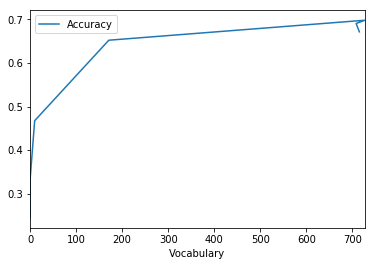

In [14]:
np.random.seed(0)

# Reset Train and Dev Matrices
devMatrix = countVectorBase.transform(dev_data)
trainMatrix = countVectorBase.fit_transform(train_data)

print '\033[1m' + 'Logistic Regression with L1 Regularization' + '\033[0m'

# Train L1 logistic regression model
logRegL1 = LogisticRegression(penalty='l1')
logRegL1.fit(trainMatrix, train_labels)
logRegL1Pred = logRegL1.predict(devMatrix)
print 'F1 score of Logistic Regression with L1 Regularization: ', metrics.f1_score(dev_labels, logRegL1Pred, average = 'weighted')

# Pull Weights for L1 Regulariztion
L1Coef = np.array(logRegL1.coef_)
nonZeroWeight = []

# Get and print number of non-zero weights

for cat in L1Coef:
    for weight in cat:
        if weight > 0:
            nonZeroWeight.append(weight)

print 'The number of non-zero weights with L1 regularization is', len(nonZeroWeight), '\n'


#Train L2 logistic regression model

print '\033[1m' + 'Logistic Regression with L2 Regularization' + '\033[0m'

logRegL2 = LogisticRegression(penalty='l2')
logRegL2.fit(trainMatrix, train_labels)
logRegL2Pred = logRegL2.predict(devMatrix)
print 'F1 score of Logistic Regression with L2 Regularization: ', metrics.f1_score(dev_labels, logRegL2Pred, average = 'weighted')
   

# Get and print number of non-zero weights

L2Coef = np.array(logRegL2.coef_)   

for cat in L2Coef:
    for weight in cat:
        if weight > 0:
            nonZeroWeight.append(weight)

print 'The number of non-zero weights with L2 regularization is', len(nonZeroWeight)


print '\n','\033[1m' + 'Refit Logistic Regression-L2 with Non-Zero L1 Vocabulary' + '\033[0m'


# Build vocabulary of all non-zero weighted features from L1 Coefficients

aggWeight = L1Coef[0]   

for index, cat in enumerate(L1Coef):
        if index == 0:
            continue
        else:
            for w, weight in enumerate(cat):
                if weight > 0:
                    aggWeight[w] += weight
    
featureNames = countVectorBase.get_feature_names()

indexVocab = np.array(np.nonzero(aggWeight)[0])
indexVocab.astype(int)
NewVocab = []
for index in indexVocab:
    NewVocab.append(featureNames[index])

# Refiting L2 model with non-zero L1 Vocabulary    
    
countVector = CountVectorizer(vocabulary = NewVocab)
refitMatrix = countVector.fit_transform(train_data)
refitDevMatrix = countVector.transform(dev_data)
logRegL2.fit(refitMatrix, train_labels)
logRegL2Pred = logRegL2.predict(refitDevMatrix)

print 'F1 score of Logistic Regression with L2 Regularization: ', metrics.f1_score(dev_labels, logRegL2Pred, average = 'weighted')
   
# Accuracy of L1 at various levels of C (and various vocabulary sizes)

cValue = 0.00001
cValues = []
totalVocab = []
totalAccuracy = []

while cValue < 101:
    logRegL2 = LogisticRegression(penalty='l1', C = cValue, tol = 0.01)
    logRegL2.fit(refitMatrix, train_labels)
    logRegL2Pred = logRegL2.predict(refitDevMatrix)
    #Store each value of C
    cValues.append(cValue)
    #Get Vocab (i.e. number of non-zero weights) for each value of C
    L2Coef = np.array(logRegL2.coef_)
    totalWeight = L2Coef[0]
    nonZeroWeight = []
    for index, cat in enumerate(L2Coef):
        if index == 0:
            continue
        else:
            for w, weight in enumerate(cat):
                if weight > 0:
                    totalWeight[w] += weight
    for weight in totalWeight:
        if weight > 0:
            nonZeroWeight.append(weight)
    totalVocab.append(len(nonZeroWeight))
    totalAccuracy.append(metrics.accuracy_score(dev_labels,logRegL2Pred))
    cValue *= 10 

# Create Data Frame of Vocabulary and Accuracy scores    

cvalDf = {'C': cValues, 'Vocabulary': totalVocab, 'Accuracy': totalAccuracy}
newDf = pd.DataFrame(data=cvalDf)

# Plot of Accuracy with increasing Vocab size by adjusting the C-value

plot = newDf.plot.line(x = 'Vocabulary', y = 'Accuracy')
print newDf               



(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.


In [16]:

tfidf = TfidfVectorizer()
tfidfData = tfidf.fit_transform(train_data)
tfidfDevData = tfidf.transform(dev_data)
logRegTfidf = LogisticRegression(C=100)
logRegTfidf.fit(tfidfData, train_labels)
tfidfPreds = logRegTfidf.predict(tfidfDevData)

devProb = logRegTfidf.predict_proba(tfidfDevData)

maxProb = []
correctProb = []
rScores = []

print '\n','\033[1m' + 'Sorted Table of R ratios for Dev Data' + '\033[0m'

for index, i in enumerate(dev_labels):
    docProbs = devProb[index]
    maxProb.append(max(docProbs))
    correctProb.append(docProbs[i])
    rScores.append(max(docProbs)/docProbs[i])
    
rvalDf = {'Correct': dev_labels, 'Predict': tfidfPreds, 'R Ratio': rScores}
rDf = pd.DataFrame(data=rvalDf)
rDf = rDf.sort_values(by = ['R Ratio'], ascending = False)
print rDf[1:5]

print '\n','\033[1m' + 'Three Documents with highest R ratio' + '\033[0m'

print '\033[1m' + 'Document #1' + '\033[0m', dev_data[665],'\n', '\033[1m' + 'Label #1' + '\033[0m', dev_labels[665], '\n','\033[1m' + 'Document #2' + '\033[0m', dev_data[607],'\n','\033[1m' + 'Label #2' + '\033[0m', dev_labels[607], '\n', '\033[1m' + 'Document #3' + '\033[0m', dev_data[655],'\n', '\033[1m' + 'Label #3' + '\033[0m', dev_labels[655]

print '\n','\033[1m' + 'Model Performance' + '\033[0m'

print classification_report(dev_labels, tfidfPreds)
    



Sorted Table of R ratios for Dev Data
     Correct  Predict     R Ratio
665        3        1  325.004068
607        0        3  287.179193
655        3        0  212.092730
287        0        3  159.144409

Three Documents with highest R ratio
Document #1 Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible. 
Label #1 3 
Document #2 
The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

Label #2 0 
Document #3 In <1ren9a$94q@morrow.stanford.edu> salem@pangea.Stanford.EDU (Bruce Salem) 



This brings up another something I have never understood.  I asked this once
before and got a few interesting responses, but somehow didn't seem satisfied.
Why would the NT NOT be considered a good source.  This might be a 
literary/historical question, but when I studied history I always looked for 
firsthand original sources to w

The model appears to be misclassifying talk/religion/misc (Class 3) as alt/atheism (Class 0). In the previous analysis of highest weighted bigram features in P4, it was noted that these classes had a few high weighted features in common. This would explain why the model is having a difficult time correctly classifying these two categories. One way to address this issue would be to include any highly weighted words shared between both classes as stop words. 

(8) Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.


In [17]:
# Implementation of basic stopwords to improve classification performacne

stopWords = ['Mormon', 'mormon', 'Bible', 'bible', 'Christian', 'christian','religion', 'Religion']

stopVectorizer = TfidfVectorizer(stop_words = stopWords)
finalData = stopVectorizer.fit_transform(train_data)
finalDevData = stopVectorizer.transform(dev_data)
logRegStop = LogisticRegression(C=100)
logRegStop.fit(finalData, train_labels)
finalPreds = logRegStop.predict(finalDevData)

print '\n','\033[1m' + 'Old Model Performance' + '\033[0m'

print classification_report(dev_labels, tfidfPreds)

print '\n','\033[1m' + 'New Model Performance' + '\033[0m'

print classification_report(dev_labels, finalPreds)



Old Model Performance
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       165
           1       0.80      0.91      0.85       185
           2       0.83      0.83      0.83       199
           3       0.68      0.64      0.66       127

   micro avg       0.76      0.76      0.76       676
   macro avg       0.75      0.75      0.75       676
weighted avg       0.76      0.76      0.76       676


New Model Performance
              precision    recall  f1-score   support

           0       0.70      0.65      0.68       165
           1       0.81      0.90      0.85       185
           2       0.82      0.83      0.83       199
           3       0.71      0.65      0.68       127

   micro avg       0.77      0.77      0.77       676
   macro avg       0.76      0.76      0.76       676
weighted avg       0.77      0.77      0.77       676



By removing a few of the highest weighted words in both class 3 and class 0 I was able to improve precision, recall and f1-score across the board with limited impact on the performance in other categories.